In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd

In [97]:
datafile = 'ex4/ex4data1.mat'
data = sio.loadmat(datafile)
# Features and labels
X, Y = data['X'], data['y']
# Store number of training examples

# Store size of layers
input_layer_size = X.shape[1]

print Y.shape
print X.shape

(5000, 1)
(5000, 400)


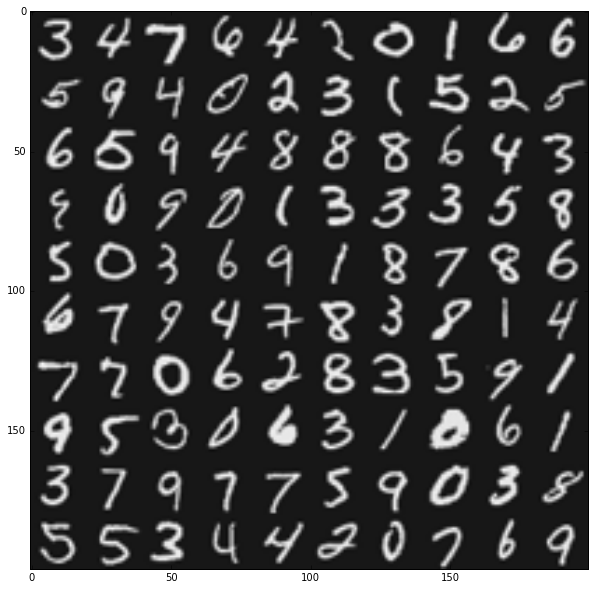

In [98]:
import random
import scipy.misc

# Compute number of items to display
display_rows, display_cols = 10, 10

total_digits = display_rows * display_cols

# Compute the size of each item to be displayed
example_height, example_width = 20, 20

# Get random indices to be displayed.
# random.sample(population,k) 
# where k is the number of items to select from the population
rows_to_display = random.sample(range(X.shape[0]),total_digits)

# Create initial picture by multiplying
# the number of rows to be displayed + the height of one digit
# and the nubmer of cols to be displayed + the width of one digit
picture = np.zeros((display_rows * example_height, display_cols * example_width))

curr_row, curr_col = 0, 0
for row in rows_to_display:
    if curr_col == display_cols:
        curr_col = 0
        curr_row += 1
    
    # Get digit image from 400x1 row. (Transform to 20x20)
    curr_digit = X[row].reshape(example_height, example_width).T
    
    # Row and col to be replaced with digit
    modified_row = curr_row * example_height
    modified_col = curr_col * example_width
    
    # Get specific and replace
    picture[modified_row:modified_row + curr_digit.shape[0],modified_col:modified_col + curr_digit.shape[1]] = curr_digit
    curr_col += 1

# Display image
image = scipy.misc.toimage(picture)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')

In [99]:
# Add column of 1s (bias unit)
X = np.insert(X,0,1,axis=1)

### Feedforward and cost function


In [100]:
# Load pre-trained weights

weightsfile = 'ex4/ex4weights.mat'
test_weights = sio.loadmat(weightsfile)
Theta1, Theta2 = test_weights['Theta1'], test_weights['Theta2']

print Theta1.shape
print Theta2.shape


(25, 401)
(10, 26)


In [101]:
from scipy.special import expit

def sigmoid(z):
    return expit(z)

def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [102]:
def forward_prop(thetas, input_units):
    # input_units = X
    
    # Store zs and activation units
    activations = [(0,input_units)]
    for index,theta in enumerate(thetas):
        activation_units = activations[-1][1]
        # compute and append z
        z = np.dot(activation_units, theta.T)
        # compute next activation units
        a = sigmoid(z)
        # insert bias unit
        if index != len(thetas) - 1:
            a = np.insert(a,0,1,axis=1)
        activations.append((z,a))
    
    return activations

In [107]:
def cost_function(nn_params,input_layer_size,hidden_layer_size,output_layer_size,X,Y,lmbda=0.):
    # nn_params = weights for our neural network rolled into 1 vector.
    
    m = len(Y)
    
    # Initially we need to unroll our weights.
    # The '+1s' are from the bias unit
    theta1 = nn_params[:(hidden_layer_size * (input_layer_size+1))].reshape(hidden_layer_size,(input_layer_size+1))
    theta2 = nn_params[(hidden_layer_size * (input_layer_size+1)):].reshape(output_layer_size,hidden_layer_size+1)
    
    # Compute our output layer
    # Forward prop
    activations = forward_prop([theta1,theta2],X)
    output_units = activations[-1][1]
    
    # Compute y matrix as eye matrix of all labels
    y_matrix = pd.get_dummies(Y.ravel()).as_matrix() # 5000 x 10
    
    total_cost_regularized = (1./m)*np.sum((np.log(output_units)*(-y_matrix)-np.log(1-output_units)*(1-y_matrix))) \
    + float(lmbda)/(2.0*m) * (np.sum(np.square(theta1.T[1:])) + np.sum(np.square(theta2.T[1:])))

    
    return total_cost_regularized

In [110]:
def backward_prop(thetas, X, Y):
    # Forward prop
    activations = forward_prop([theta1,theta2],X)
    output_units = activations[-1][1]
    
    theta1 = thetas[0]
    theta2 = thetas[1]
        
    # Compute y matrix as eye matrix of all labels
    y_matrix = pd.get_dummies(Y.ravel()).as_matrix() # 5000 x 10
    
    # Backprop
    d3 = (output_units - y_matrix) # 5000x10
    d2 = np.dot(theta2[:,1:].T,d3.T).T * sigmoid_gradient(z2) # 5000 x 25
    
    D1 = np.dot(d2.T, a1)
    D2 = np.dot(d3.T, a2)
    
    theta_gradient1 = D1[:,1:] * 1./float(m) + float(lmbda)/m * theta1[:,1:]
    theta_gradient2 = D2[:,1:] * 1./float(m) + float(lmbda)/m * theta2[:,1:]
    
    return theta_gradient1, theta_gradient2

In [111]:
"""
Implement the cost function and gradient for the neural network
You should see that the cost is about 0.287629 non-regularized and
0.383769859091 for regularized with lambda = 1
"""
# Roll thetas into a single vector
nn_params = np.concatenate([Theta1.ravel(),Theta2.ravel()])
# Setup size of layers in neural network
hidden_layer_size = Theta1.shape[0]
output_layer_size = Theta2.shape[0]

# Compute non-regularized cost, should be equal to 0.287629
non_reg_cost = cost_function(nn_params,input_layer_size,hidden_layer_size,output_layer_size,X,Y)

# Compute regularized cost with lambda=1, should be equal to 0.383769859091
reg_cost = cost_function(nn_params,input_layer_size,hidden_layer_size,output_layer_size,X,Y,1)

print "Regularized cost: {}, non-regularized cost: {}".format(reg_cost,non_reg_cost)

Regularized cost: 6.93133852584, non-regularized cost: 6.93133852238


### Random initialization

In [109]:
epsilon = 1e-4
Theta1 = np.random.random((hidden_layer_size,X.shape[1])) * 2 * epsilon - epsilon #25 x 401
Theta2 = np.random.random((output_layer_size,hidden_layer_size+1)) * 2 * epsilon - epsilon # 10 x 26
